Same as final-notebook except this one doesn't keep all objects in the same matrix

In [2]:
# Reading the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187
objectsplit = 26

layersPerObject = endlayer // objectsplit
# Approximate one third test data
testEnd = endlayer - layersPerObject * (objectsplit // 3)

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted

In [3]:
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject, layersPerObject)]
testzs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(testEnd, endlayer-layersPerObject+1, layersPerObject)]

trainobjectinfo = pd.concat(zs, ignore_index=True)
testobjectinfo = pd.concat(testzs, ignore_index=True)
del zs
del testzs
del coorddf
del objectCoordinates
del objectinfo

trainobjectinfo.drop(trainobjectinfo[trainobjectinfo.Label == 'KH'].index, inplace=True)
trainobjectinfo.replace('GOOD', 0, inplace=True)
trainobjectinfo.replace('LOF', 1, inplace=True)
trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.drop(testobjectinfo[testobjectinfo.Label == 'KH'].index, inplace=True)
testobjectinfo.replace('GOOD', 0, inplace=True)
testobjectinfo.replace('LOF', 1, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)

# Double check maybe that iterrows gives the correct order?
for index, object in trainobjectinfo.iterrows():
    trainobjects[index-1] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index-1] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

In [25]:
# im = cv.imread('test.jpg')

i = 0

kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# Behöver normalisera. Det här är ju dumt...

for object in trainobjects:
    i+=1
    img = cv2.filter2D(src=object[1], ddepth=-1, kernel=kernel)
    # imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 1500, 255, 0)
    plt.imshow(thresh)
    plt.title("Threshold for image " + str(i))
    plt.figure()
    plt.imshow(object[1])
    plt.title("Original image " + str(i))
    plt.figure()
    thresh=thresh.astype(np.uint8)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, 3, (0,255,0), 3)


/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_86737/3837975780.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

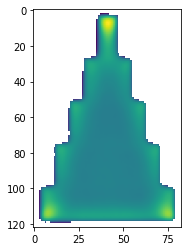

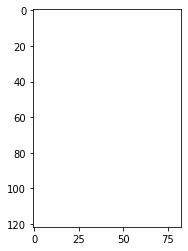

<Figure size 432x288 with 0 Axes>

In [16]:
aggregate = np.sum(trainobjects, axis=(0,1))
aggregate2 = np.sum(testobjects, axis=(0,1))
aggregate += aggregate2
plt.imshow(aggregate)
plt.figure()

# Sharpening
sharpeningKernel = np.array([   [ -1, -1,  -1],
                                [-1,  9, -1],
                                [ -1, -1,  -1]
                            ])
sharpened = cv2.filter2D(src=aggregate, ddepth=-1, kernel=sharpeningKernel)
# End of sharpening
# Start of filtering
# A better approach to filtering would be some sort of clustering or image segmentation
emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
filter = aggregate >= limit
minval = np.min(img)
maxval = np.max(img)
middle = (minval + maxval) / 2
xs = np.copy(aggregate)
xs[~filter] = np.nan
plt.imshow(xs)
plt.figure()

/var/folders/d9/k1mwdb1x1sb5ly3k528g3qcr0000gn/T/ipykernel_87167/3893251553.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


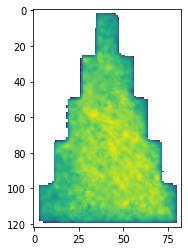

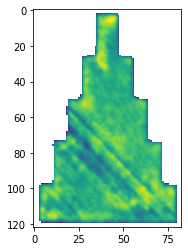

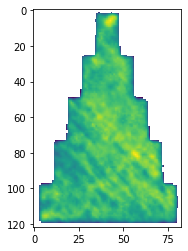

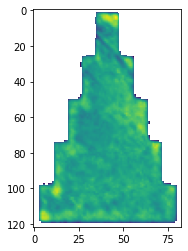

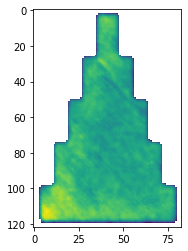

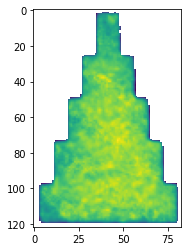

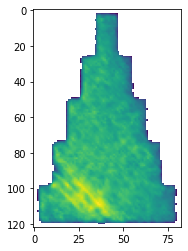

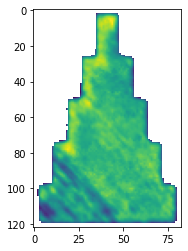

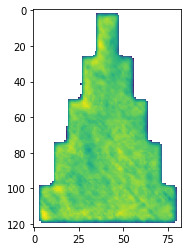

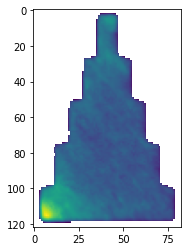

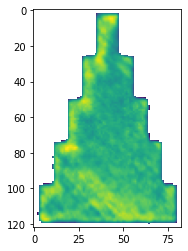

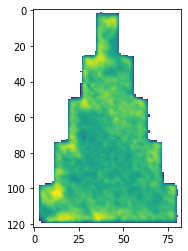

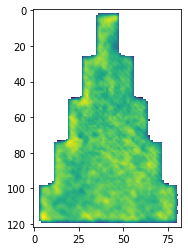

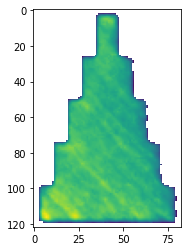

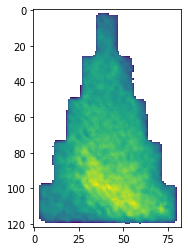

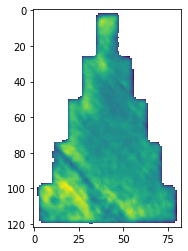

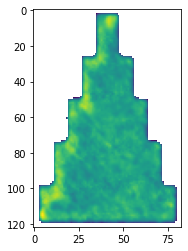

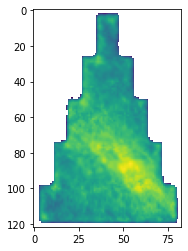

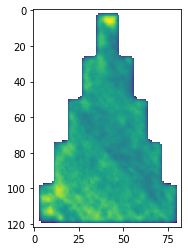

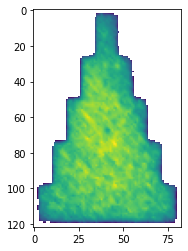

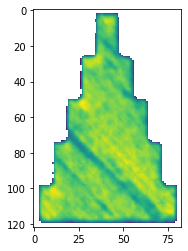

<Figure size 432x288 with 0 Axes>

In [15]:
# im = cv.imread('test.jpg')

i = 0

kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# Behöver normalisera. Det här är ju dumt...

for object in trainobjects:
    i+=1
    img = object[1]
    minval = np.min(img)
    maxval = np.max(img)
    middle = (minval + maxval) / 2
    filter = img >= middle
    img[~filter] = np.nan
    plt.imshow(img)
    plt.figure()
    if i > 20:
        break
